In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn
from tensorflow.examples.tutorials.mnist import input_data

config=tf.ConfigProto()
config.gpu_options.allow_growth=True
sess=tf.Session(config=config)

mnist = input_data.read_data_sets('MNIST_data',one_hot=True)
print(mnist.train.images.shape)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
(55000, 784)


In [2]:


lr = 1e-3
input_size = 28      # 每个时刻的输入特征是28维的，就是每个时刻输入一行，一行有 28 个像素
timestep_size = 28   # 时序持续长度为28，即每做一次预测，需要先输入28行
hidden_size = 256    # 隐含层的数量
layer_num = 2        # LSTM layer 的层数
class_num = 10       # 最后输出分类类别数量，如果是回归预测的话应该是 1

_X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, class_num])
# 在训练和测试的时候，我们想用不同的 batch_size.所以采用占位符的方式
batch_size = tf.placeholder(tf.int32, [])  # 注意类型必须为 tf.int32, batch_size = 128
keep_prob = tf.placeholder(tf.float32, [])

In [3]:
# 把784个点的字符信息还原成 28 * 28 的图片
# 下面几个步骤是实现 RNN / LSTM 的关键
####################################################################
# **步骤1：RNN 的输入shape = (batch_size, timestep_size, input_size) 
X = tf.reshape(_X, [-1, 28, 28])

# # **步骤2：定义一层 LSTM_cell，只需要说明 hidden_size, 它会自动匹配输入的 X 的维度
# lstm_cell = rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=1.0, state_is_tuple=True)

# # **步骤3：添加 dropout layer, 一般只设置 output_keep_prob
# lstm_cell = rnn.DropoutWrapper(cell=lstm_cell, input_keep_prob=1.0, output_keep_prob=keep_prob)

# # **步骤4：调用 MultiRNNCell 来实现多层 LSTM
# mlstm_cell = rnn.MultiRNNCell([lstm_cell] * layer_num, state_is_tuple=True)
# mlstm_cell = rnn.MultiRNNCell([lstm_cell for _ in range(layer_num)] , state_is_tuple=True)

# 在 tf 1.0.0 版本中，可以使用上面的 三个步骤创建多层 lstm， 但是在 tf 1.2.1 版本中，可以通过下面方式来创建
def lstm_cell():
    cell = rnn.LSTMCell(hidden_size, reuse=tf.get_variable_scope().reuse)
    return rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)

mlstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(layer_num)], state_is_tuple = True)

# **步骤5：用全零来初始化state
init_state = mlstm_cell.zero_state(batch_size, dtype=tf.float32)

# **步骤6：方法一，调用 dynamic_rnn() 来让我们构建好的网络运行起来
# ** 当 time_major==False 时， outputs.shape = [batch_size, timestep_size, hidden_size] 
# ** 所以，可以取 h_state = outputs[:, -1, :] 作为最后输出
# ** state.shape = [layer_num, 2, batch_size, hidden_size], 
# ** 或者，可以取 h_state = state[-1][1] 作为最后输出
# ** 最后输出维度是 [batch_size, hidden_size]
outputs, state = tf.nn.dynamic_rnn(mlstm_cell, inputs=X, initial_state=init_state, time_major=False)
h_state = state[-1][1]

# *************** 为了更好的理解 LSTM 工作原理，我们把上面 步骤6 中的函数自己来实现 ***************
# 通过查看文档你会发现， RNNCell 都提供了一个 __call__()函数，我们可以用它来展开实现LSTM按时间步迭代。
# **步骤6：方法二，按时间步展开计算
# outputs = list()
# state = init_state
# with tf.variable_scope('RNN'):
#     for timestep in range(timestep_size):
#         if timestep > 0:
#             tf.get_variable_scope().reuse_variables()
#         # 这里的state保存了每一层 LSTM 的状态
#         (cell_output, state) = mlstm_cell(X[:, timestep, :],state)
#         outputs.append(cell_output)
# h_state = outputs[-1]

In [5]:
W=tf.Variable(tf.truncated_normal([hidden_size,class_num],stddev=0.1),dtype=tf.float32)
bias=tf.Variable(tf.constant(0.1,shape=[class_num]),dtype=tf.float32)
y_pred=tf.nn.softmax(tf.matmul(h_state,W)+bias)
cross_entropy=-tf.reduce_mean(y*tf.log(y_pred))
train_op=tf.train.AdamOptimizer(lr).minimize(cross_entropy)

correct_prediction=tf.equal(tf.argmax(y_pred,1),tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,"float"))

sess.run(tf.global_variables_initializer())
for i in range(2000):
    _batch_size=128
    batch=mnist.train.next_batch(_batch_size)
    if (i+1)%200 ==0:
        train_accuracy=sess.run(accuracy,feed_dict={
            _X:batch[0],y:batch[1],keep_prob:1.0,batch_size:_batch_size
        })
        print(y_pred)
        print(batch[0].shape)
        print("Iter%d, step %d, training accuracy %g" % (mnist.train.epochs_completed,(i+1),train_accuracy))
    sess.run(train_op,feed_dict={_X:batch[0],y:batch[1],keep_prob:0.5,batch_size:_batch_size})
print("test accuracy %g"% sess.run(accuracy,feed_dict={
    _X:mnist.test.images,y:mnist.test.labels,keep_prob:1.0,batch_size:mnist.test.images.shape[0]
}))

Tensor("Softmax_1:0", shape=(?, 10), dtype=float32)
(128, 784)
Iter5, step 200, training accuracy 0.9375
Tensor("Softmax_1:0", shape=(?, 10), dtype=float32)
(128, 784)
Iter5, step 400, training accuracy 0.976562
Tensor("Softmax_1:0", shape=(?, 10), dtype=float32)
(128, 784)
Iter6, step 600, training accuracy 0.96875
Tensor("Softmax_1:0", shape=(?, 10), dtype=float32)
(128, 784)
Iter6, step 800, training accuracy 0.984375
Tensor("Softmax_1:0", shape=(?, 10), dtype=float32)
(128, 784)
Iter6, step 1000, training accuracy 0.984375
Tensor("Softmax_1:0", shape=(?, 10), dtype=float32)
(128, 784)
Iter7, step 1200, training accuracy 0.984375
Tensor("Softmax_1:0", shape=(?, 10), dtype=float32)
(128, 784)
Iter7, step 1400, training accuracy 0.984375
Tensor("Softmax_1:0", shape=(?, 10), dtype=float32)
(128, 784)
Iter8, step 1600, training accuracy 0.992188
Tensor("Softmax_1:0", shape=(?, 10), dtype=float32)
(128, 784)
Iter8, step 1800, training accuracy 0.984375
Tensor("Softmax_1:0", shape=(?, 10)

In [6]:
_batch_size=5
X_batch,y_batch=mnist.test.next_batch(_batch_size)
print(X_batch.shape,y_batch.shape)
_outputs,_state=sess.run([outputs,state],feed_dict={
    _X:X_batch,y:y_batch,keep_prob:1.0,batch_size:_batch_size
})
print('outputs.shape=',np.asarray(_outputs).shape)
print('arr_state.shape=',np.asarray(_state).shape)

print(np.asarray(_state[-1][1]))
print(np.asarray(_state[0][1]))


(5, 784) (5, 10)
outputs.shape= (5, 28, 256)
arr_state.shape= (2, 2, 5, 256)
[[-0.29114476 -0.84908068 -0.02608863 ..., -0.26059726 -0.41139302
   0.59013247]
 [-0.6596756   0.1405973   0.32068741 ...,  0.78834546 -0.85109633
  -0.55030227]
 [ 0.91946286 -0.6195702   0.00405734 ...,  0.50050467  0.4910633
  -0.59666592]
 [-0.89336431  0.21388607  0.50573528 ...,  0.75225669  0.6082601
  -0.56074399]
 [-0.36205587 -0.87424242  0.77999097 ...,  0.395004   -0.788903
  -0.25867409]]
[[ 0.02811883 -0.1008996   0.03933555 ..., -0.26678833 -0.0076026
  -0.04358114]
 [-0.27545795  0.08285692 -0.09781252 ..., -0.40972584  0.14314541
   0.83173752]
 [-0.21126685  0.08805162  0.52263641 ..., -0.16019027  0.06584492
   0.14457463]
 [ 0.10716452  0.02429411  0.23363011 ...,  0.07705231  0.1158627
   0.38137382]
 [ 0.10278453 -0.19593915  0.18716493 ..., -0.15240444 -0.24707885
   0.18361446]]


In [7]:
import matplotlib.pyplot as plt

In [8]:
print(mnist.train.labels[4])

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


(28, 28)


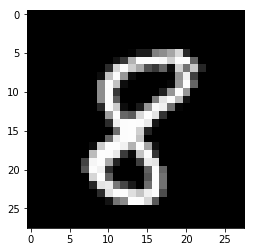

In [9]:
X3=mnist.train.images[3]
img3=X3.reshape([28,28])
print(img3.shape)
plt.imshow(img3,cmap='gray')
plt.show()

In [10]:
X3.shape=[-1,784]
y_batch=mnist.train.labels[0]
y_batch.shape=[-1,class_num]

X3_outputs=np.array(sess.run(outputs,feed_dict={
    _X:X3,y:y_batch,keep_prob:1.0,batch_size:1
}))
print(X3_outputs.shape)
X3_outputs.shape=[28,hidden_size]
print(X3_outputs.shape)

(1, 28, 256)
(28, 256)


[[-0.08456483  0.08745969 -0.07621165 ..., -0.00773322 -0.15107249
   0.10566489]
 [ 0.26069802  0.13171725  0.0247799  ...,  0.08384562  0.06285298
   0.03339371]
 [-0.02133826 -0.08564553  0.09821648 ...,  0.05742728  0.02910433
   0.17623523]
 ..., 
 [ 0.14126052  0.15447645 -0.08539373 ..., -0.27805188  0.12536794
   0.0209918 ]
 [-0.11653625  0.07422358  0.14709686 ..., -0.03686545  0.01324715
  -0.12571484]
 [-0.14584878  0.00623576  0.01669303 ...,  0.08890152 -0.1124042
  -0.15828955]]
[ 0.0999197   0.14981271  0.07992077  0.08728788  0.08243027  0.11954871
  0.08033348  0.12624525  0.10010903  0.08718728]


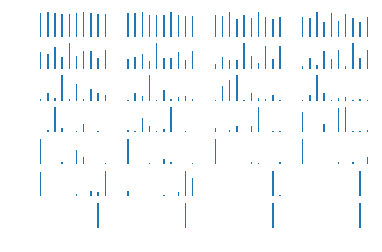

In [11]:
h_W=sess.run(W,feed_dict={
    _X:X3,y:y_batch,keep_prob:1.0,batch_size:1
})
print(h_W)
h_bias=sess.run(bias,feed_dict={
    _X:X3,y:y_batch,keep_prob:1.0,batch_size:1
})
print(h_bias)
bar_index=range(class_num)
for i in range(X3_outputs.shape[0]):
    plt.subplot(7,4,i+1)
    x3_h_shate=X3_outputs[i,:].reshape([-1,hidden_size])
    pro=sess.run(tf.nn.softmax(tf.matmul(x3_h_shate,h_W)+h_bias))
    plt.bar(bar_index,pro[0],width=0.2,align='center')
    plt.axis('off')
plt.show()